In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os, glob

%matplotlib inline

In [2]:
# make a table for the images to show them
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(16, 18))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def show_image(image):
    plt.imshow(image)


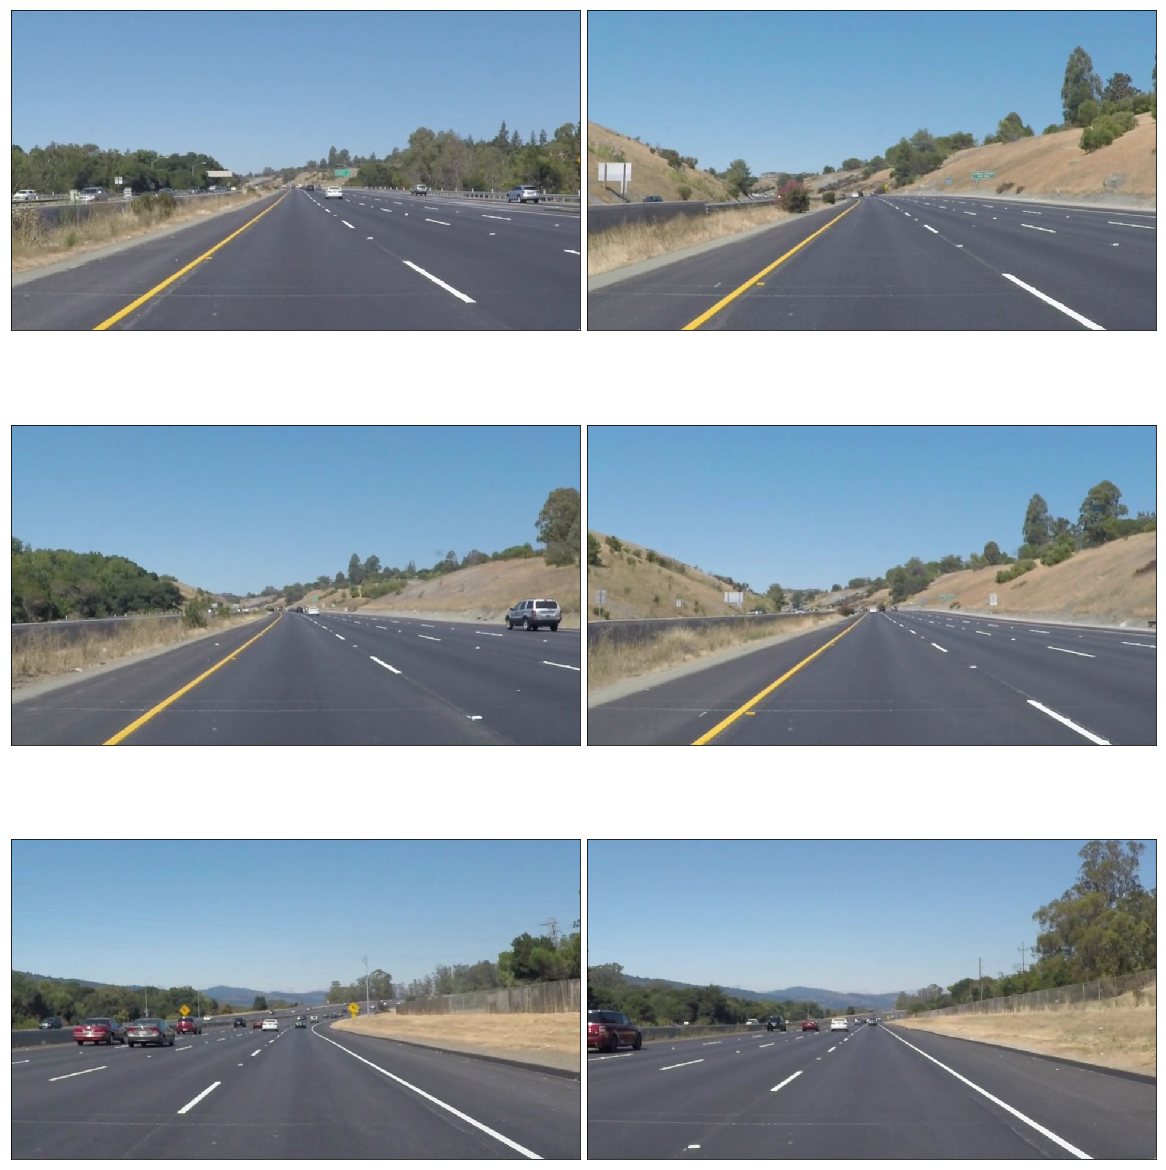

In [3]:
# load and read the images from the folder and run them under the table frame test_images is a list of images
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

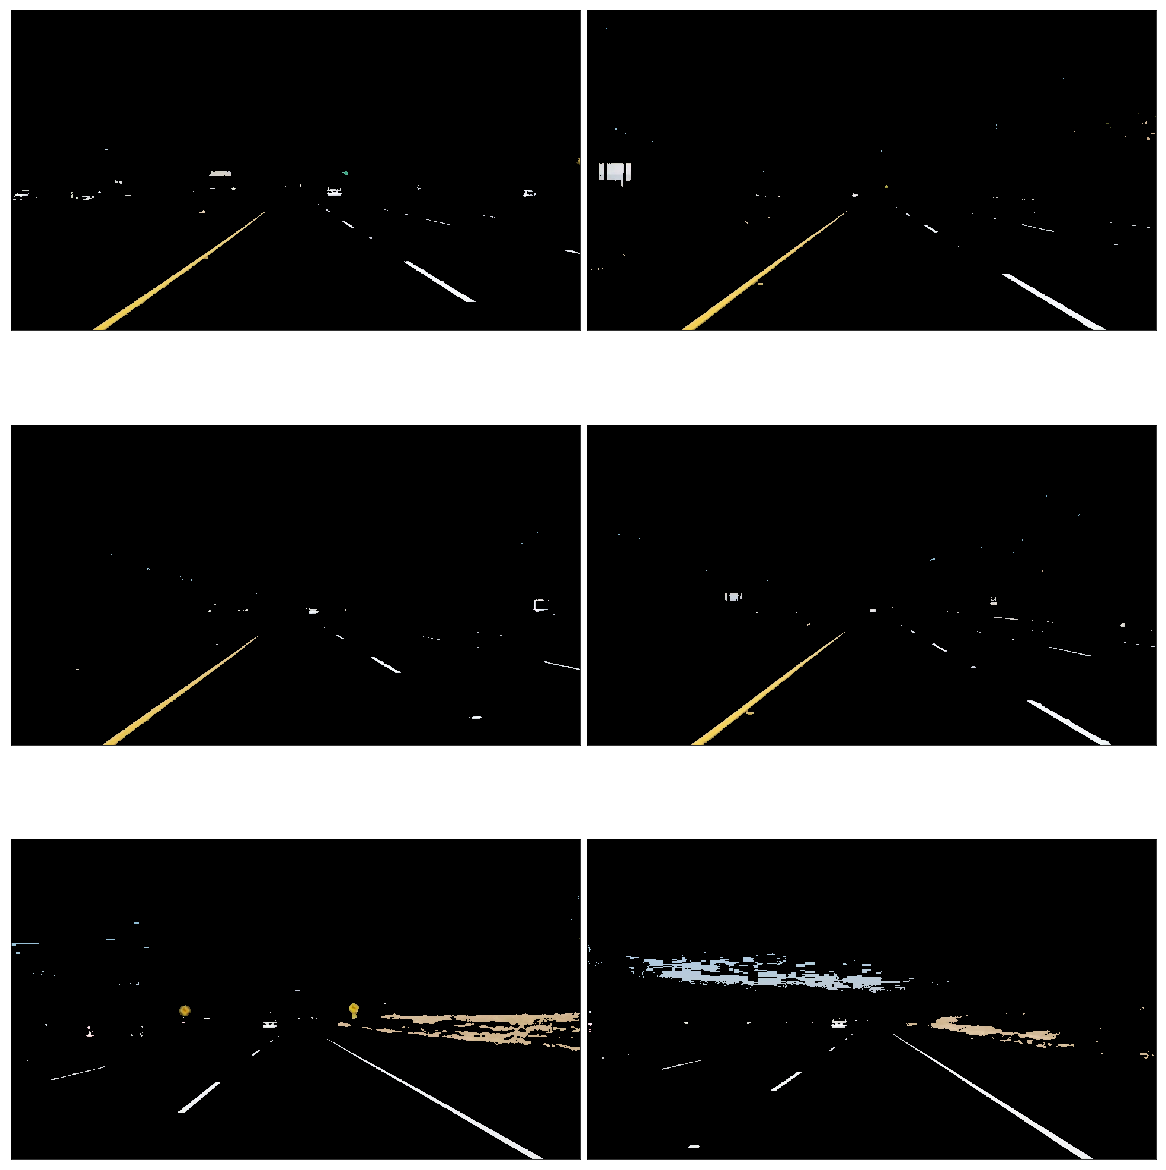

In [4]:
#filter white and yellow color out over HLS color space
def filter_yellow_white(image):
    HLS_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # filter white
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(HLS_image, lower, upper)
    # filter yellow
    lower = np.uint8([10, 0, 90])
    upper = np.uint8([100,255,255])
    yellow_mask = cv2.inRange(HLS_image, lower, upper)
    
    mixed_color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mixed_color_mask)
filtered = list(map(filter_yellow_white, test_images))
show_images(filtered)

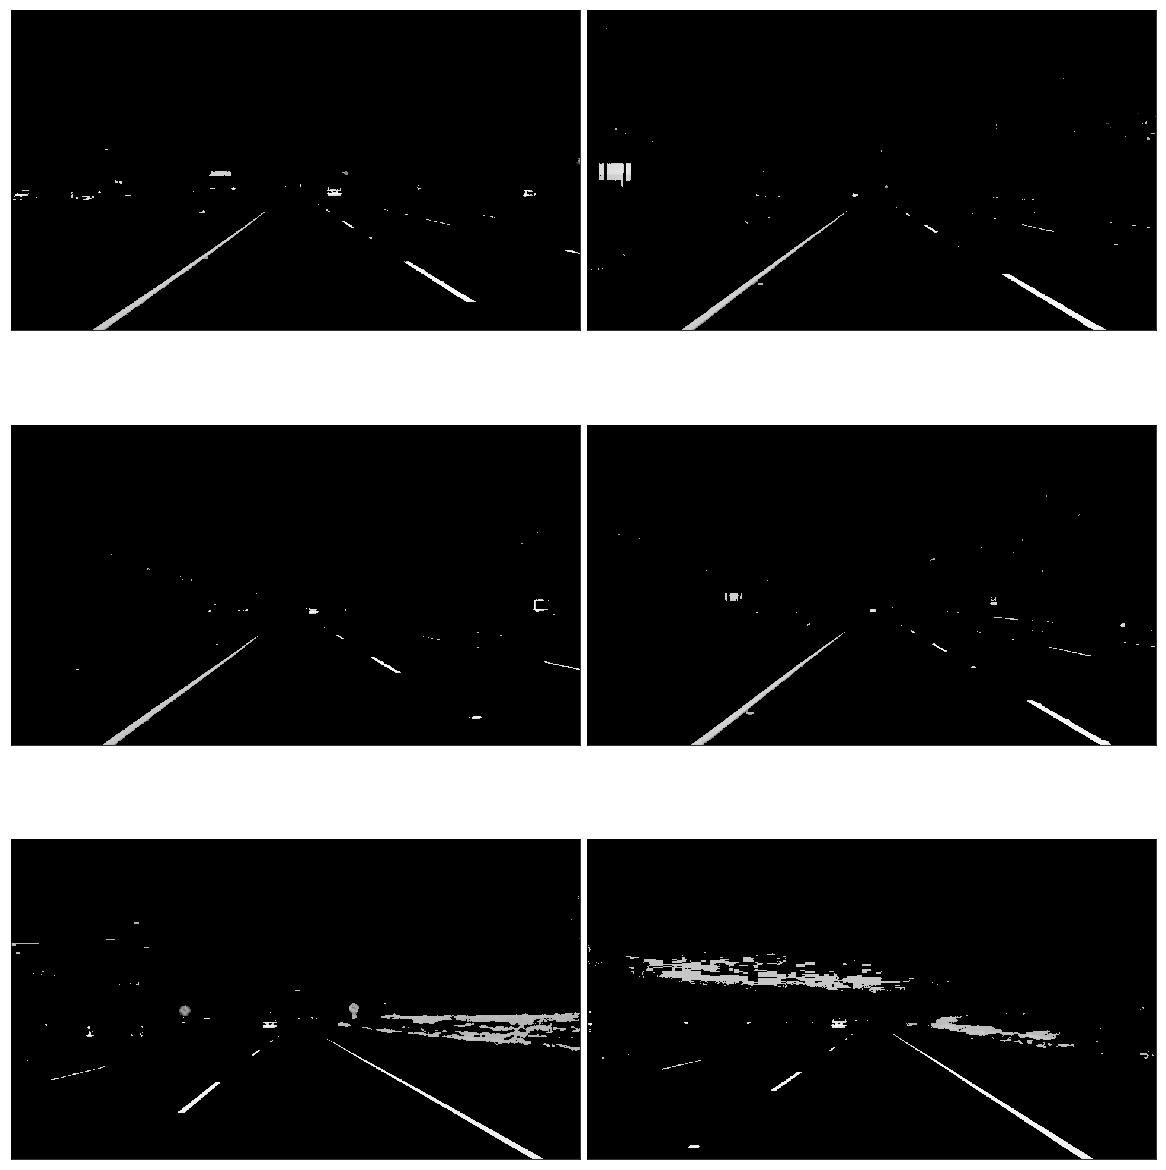

In [5]:
# take this rgb images and make them gray images
def make_them_gray(image): 
    #grayscale the image
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = list(map(make_them_gray, filtered))
show_images(gray)

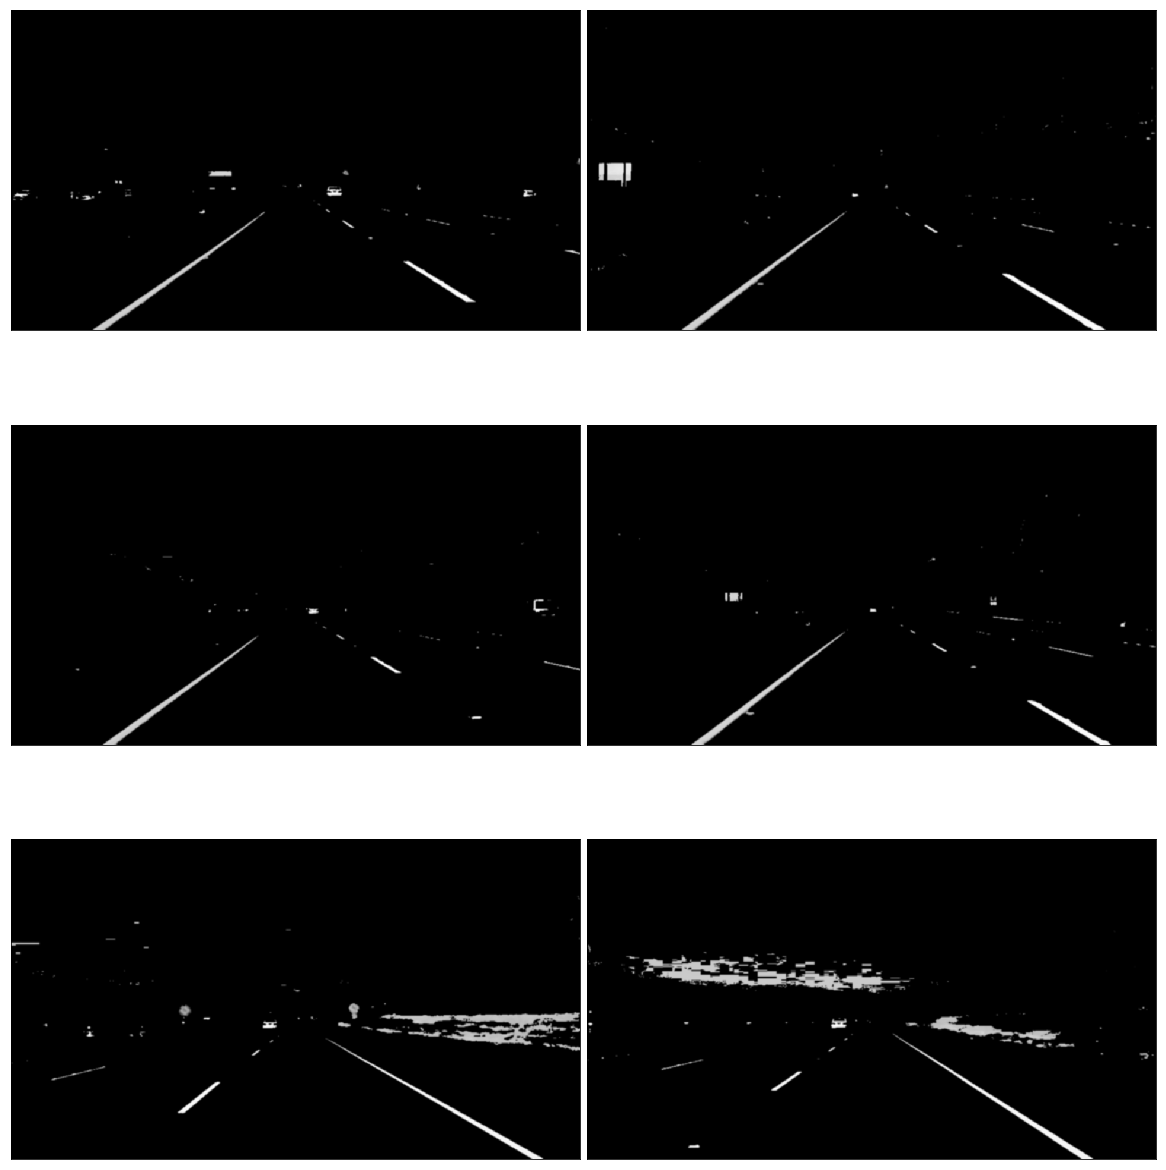

In [6]:
# choose the smoothiong level the number must be bigger than 0 and odd 1,3,5,7,...
def smoothing(image):
    kernel_size = 5
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
blurred = list(map(lambda image:smoothing(image), gray))
show_images(blurred)

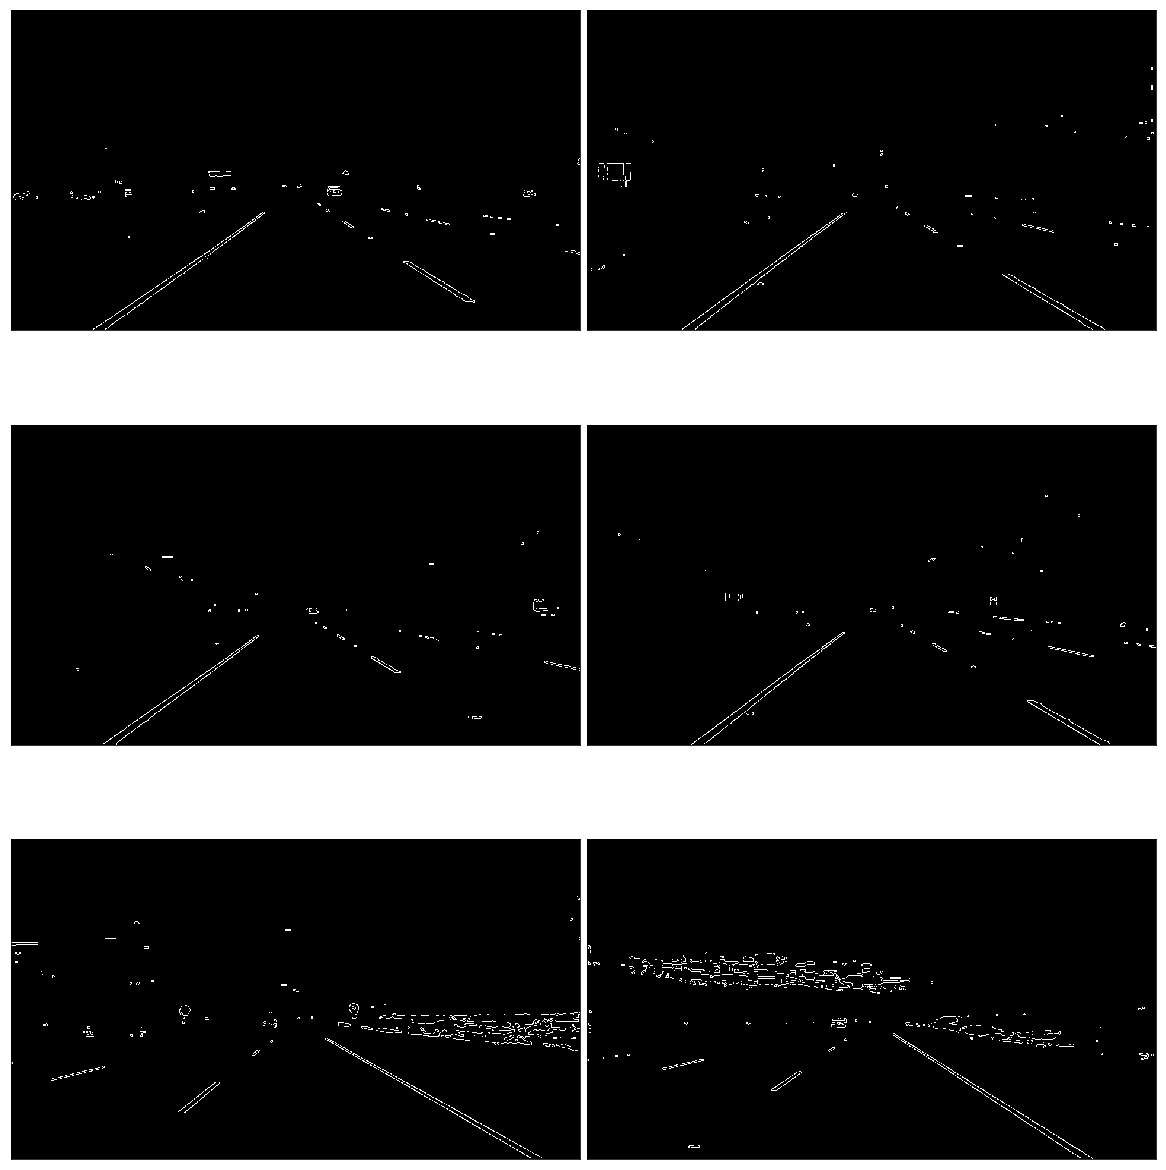

In [7]:
def make_Canny_edges(image):
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(image, low_threshold, high_threshold)
edges = list(map(lambda image:make_Canny_edges(image), blurred))
show_images(edges)

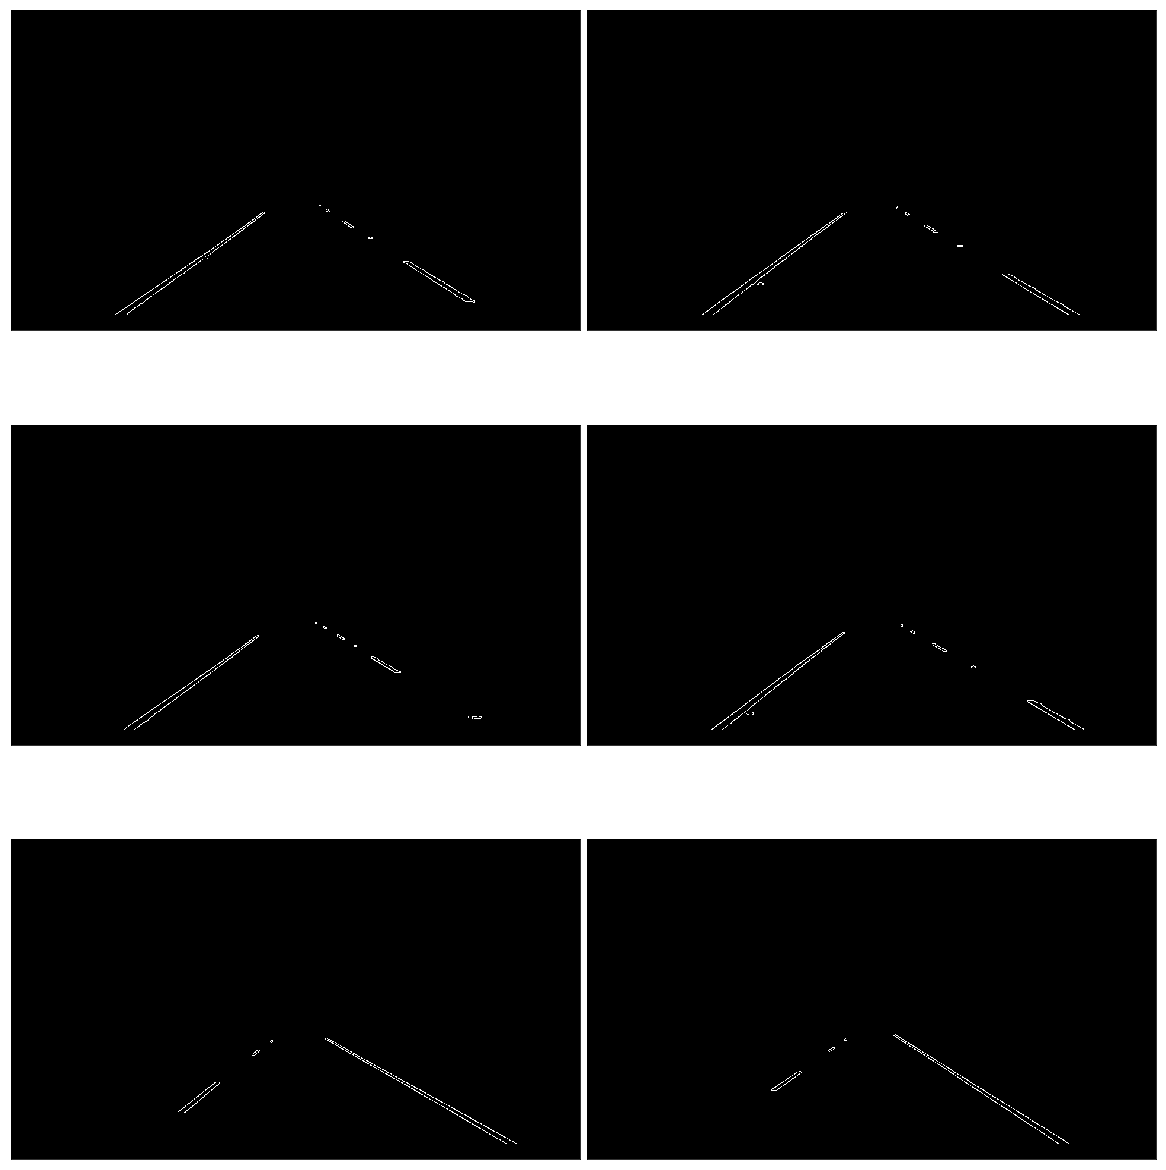

In [8]:
# fill the polygon erea with white color 255 overlap the bounded erea bitwise with the interest zone  
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)
# feeding filter_region with polygon vertices
def select_region(image):
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.16, rows*0.95]
    top_left     = [cols*0.44, rows*0.61]
    bottom_right = [cols*0.95, rows*0.95]
    top_right    = [cols*0.56, rows*0.61] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

# images showing the region of interest only
masked_edges = list(map(select_region, edges))
show_images(masked_edges)

In [9]:
def hough_lines(image):
    # Feeding HoughLinesP: into lines
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 20        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40  # minimum number of pixels making up a line
    max_line_gap = 7      # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [10]:
def blank_image(image):
    return np.copy(image)*0

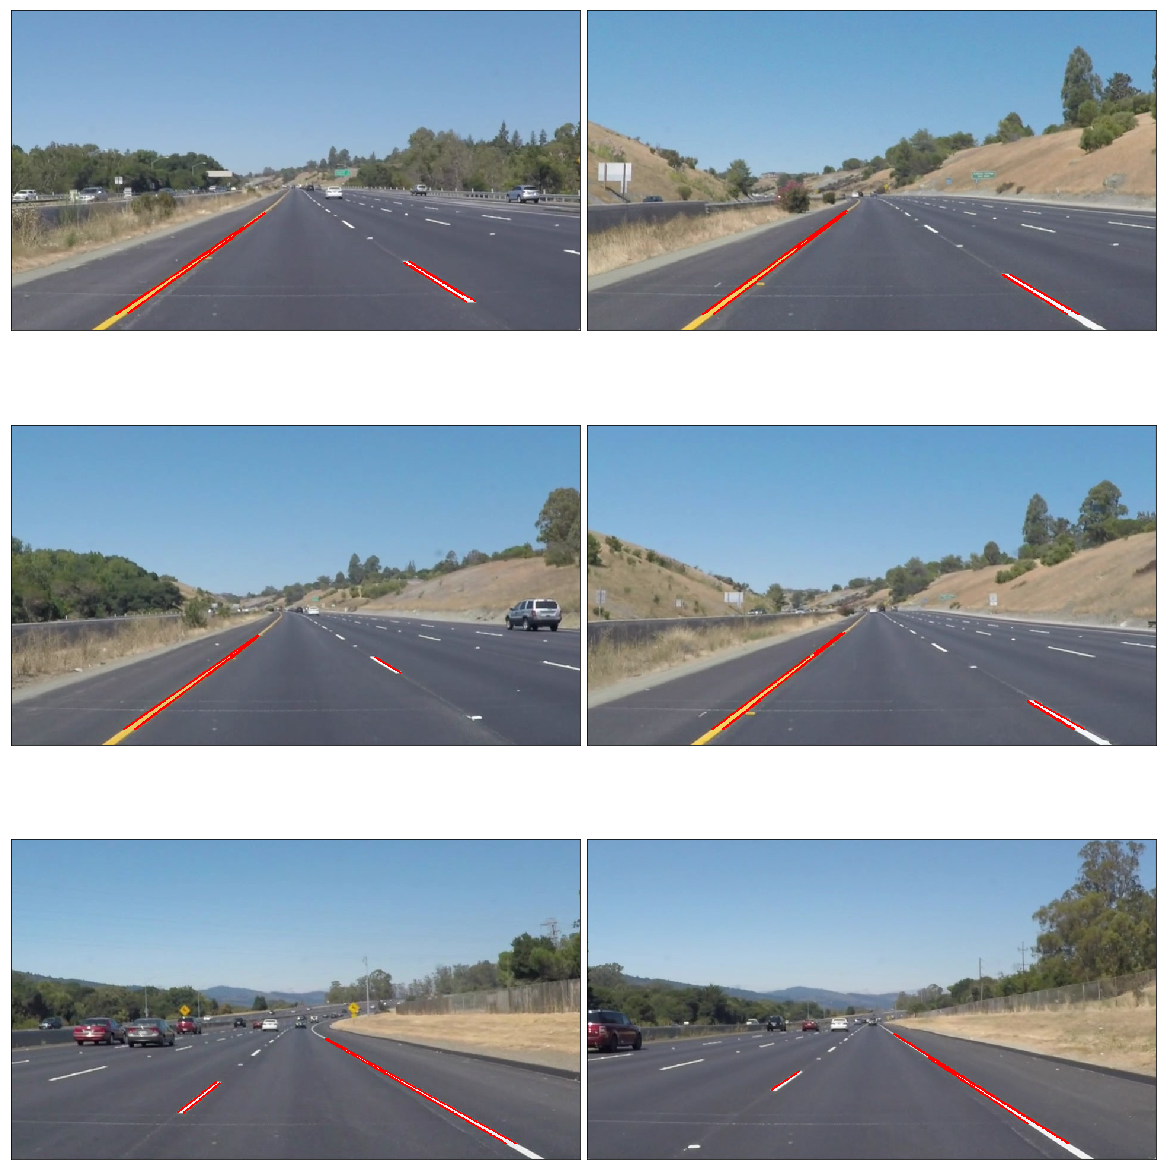

In [11]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

line_images = []
blank_images = list(map(blank_image, test_images))

list_of_lines = list(map(hough_lines, masked_edges))

for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

In [12]:
def average_slope(lines, left_aveg, right_aveg):

    # line_image is the empty dark image
    # draw the line with cv2.line
    # Iterate over the output "lines" and draw lines on a blank black image
    # as y axis goes from up to bottom and there is not a same origin for (x and y = 0) 
    # the slope > 0 apears on the left rather than on the right
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    m_left_ave    = [] #(slope average)
    m_right_ave   = [] #(slope average)
   
    m_r = [] #right line slpoe 
    b_r = [] #right line intercept 
    m_l = [] # left line slope
    b_l = [] # left line intercept
  
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
            z = np.polyfit([x1,x2], [y1,y2], 1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            # m: slope -- b: intercept
            m, b = z
            
            if abs(m) < 0.4 or abs(m) > 0.8:
                continue
            if m > 0:
                if abs(m - right_aveg[0]) > 0.5 and right_aveg[0] != 0:
                    m = right_aveg[0]
                m_r.append(m)
                b_r.append(b)
                if len(m_r) >1:
                    ave_m_r = np.mean(m_r)
                    ave_b_r = np.mean(b_r)
                else:
                    ave_m_r = m_r[0]
                    ave_b_r = b_r[0]

                z_r = np.array([ave_m_r, ave_b_r])
                if z_r is not None: 
                    right_aveg = z_r
                right_lines.append(z_r) # adding them for later building the average of 
                right_weights.append((length))
                if len(right_weights) <= 0:
                        continue                
            else:
                if abs(m - left_aveg[0]) > 0.5  and left_aveg[0] != 0:
                    m = left_aveg[0]
                m_l.append(m)
                b_l.append(b)
                if len(m_l) >1:
                    ave_m_l = np.mean(m_l)
                    ave_b_l = np.mean(b_l)
                else:
                    ave_m_l = m_l[0]
                    ave_b_l = b_l[0]                
                z_l = np.array([ave_m_l, ave_b_l])
                if z_l is not None:
                    left_aveg = z_l
                left_lines.append(z_l)
                left_weights.append((length))
                if len(left_weights) <= 0:
                        continue
        # make average of all slopes for each line and passes b unchanged to variable
    
    if len(left_lines) == 0:
        left_lines.append(left_aveg)
        left_weights.append(60)
        #return (np.poly1d([1,1]), np.poly1d([1,1]))
    if len(right_lines) == 0:
        right_lines.append(right_aveg)
        right_weights.append(30)
        #return (np.poly1d([1,1]), np.poly1d([1,1]))
        #continue
    
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    
    if right_lane is None:
        f_right = right_lane
    else:
        f_right = np.poly1d(right_lane)
    
    if left_lane is None:
        f_left = left_lane
    else:
        f_left = np.poly1d(left_lane)
        
    #m_left_ave = np.mean(left_lines, 0)
    #m_right_ave = np.mean(right_lines, 0)
    #  put the average of slopes in poly1d to gain a function of y=mx+b 
    #  poly1d is feeded with average slope of all lines and b and calculate the function y=mx+b
    #f_right = np.poly1d(m_right_ave)
    #f_left = np.poly1d(m_left_ave)
    #print(f_right, f_left, z_r, z_l)
    return (f_right, f_left, left_aveg, right_aveg)

In [13]:
#averages = list(map(average_slope, list_of_lines))
left_aveg = [0,0]
right_aveg = [0,0]
averages = [average_slope(x, left_aveg, right_aveg) for x in list_of_lines]

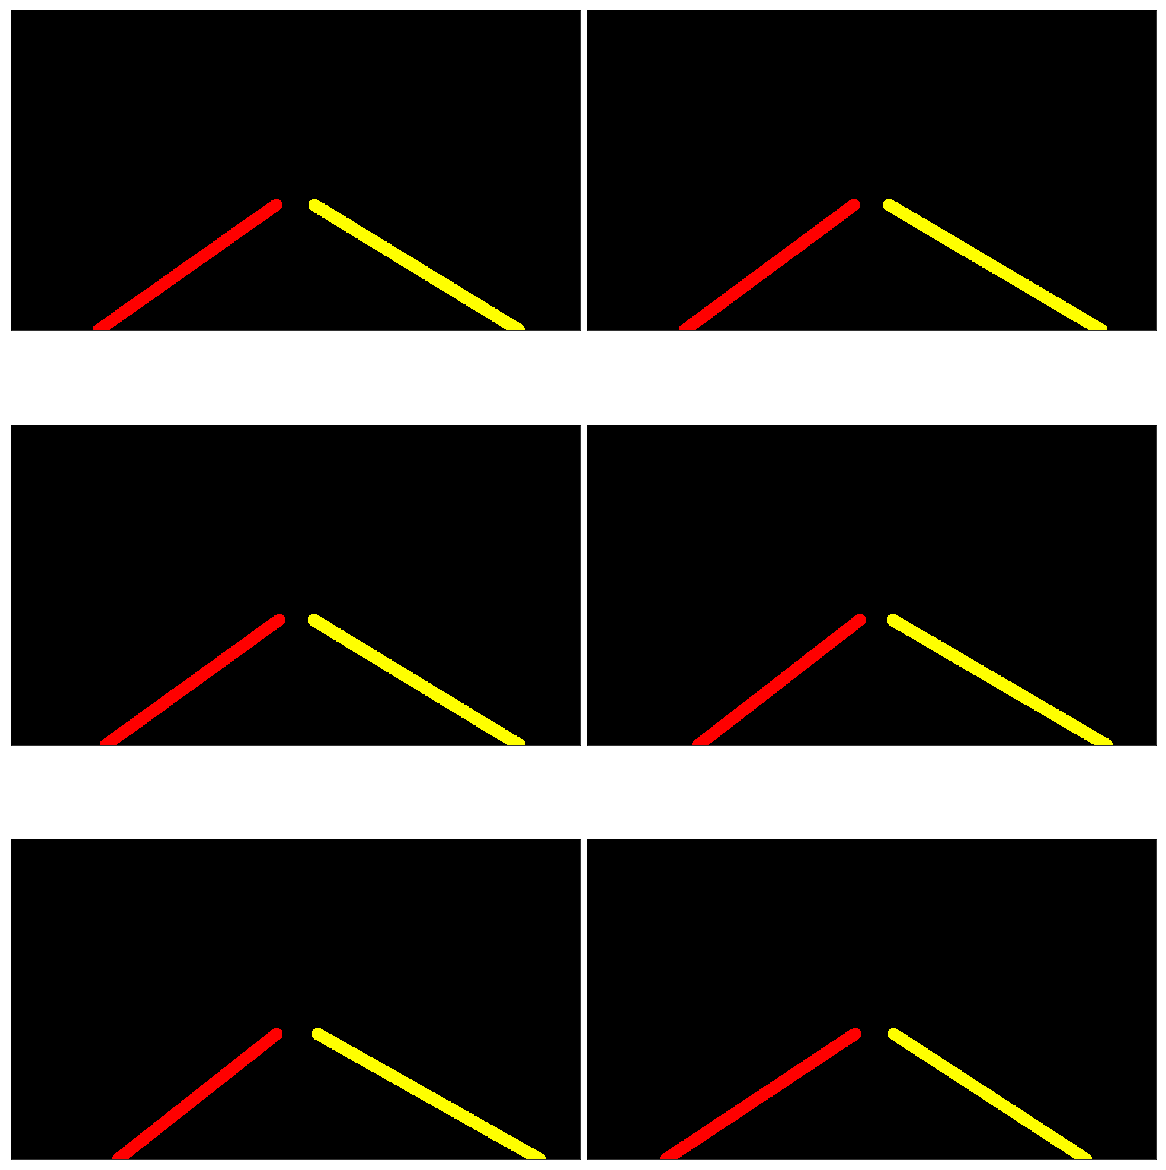

In [14]:
#extrapolation:
# use this function to make 4 points out of known line function y=mx+b 
# m is known, b is known, y1 and y2 is given to begin with 
def create_lines_average(f, thikness, image):
    blank_img = blank_image(image)
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.61        # under the horizont line -> slightly lower than the middle
    color_edge = create_lines_average_methode(y1, y2, f[0], (255,255,0), thikness, blank_img)
    color_edge = create_lines_average_methode(y1, y2, f[1], (255,0,0), thikness, blank_img)
    return color_edge

def create_lines_average_methode(y1, y2, f, color, thikness, blank_img):
    x1 = int((f - y1).roots) # calculation the x using ploy1d function
    x2 = int((f - y2).roots)
    y1 = int(y1)
    y2 = int(y2)
    #if left_lane is not None or right_lane is not None:
    color_edges = cv2.line(blank_img,(x1,y1),(x2,y2),color,thikness)
    return color_edges

color_edges = [create_lines_average(ave, 20, image) for (image ,ave) in zip(test_images, averages)]
# color_edges = []
# for (i, ave) in enumerate(averages):
#     color_edges[i] = create_lines_average(ave, i, 2)
#color_edges = list(map(lambda : create_lines_average(ave, i, thikness = 2), enumerate(averages))

show_images(color_edges)

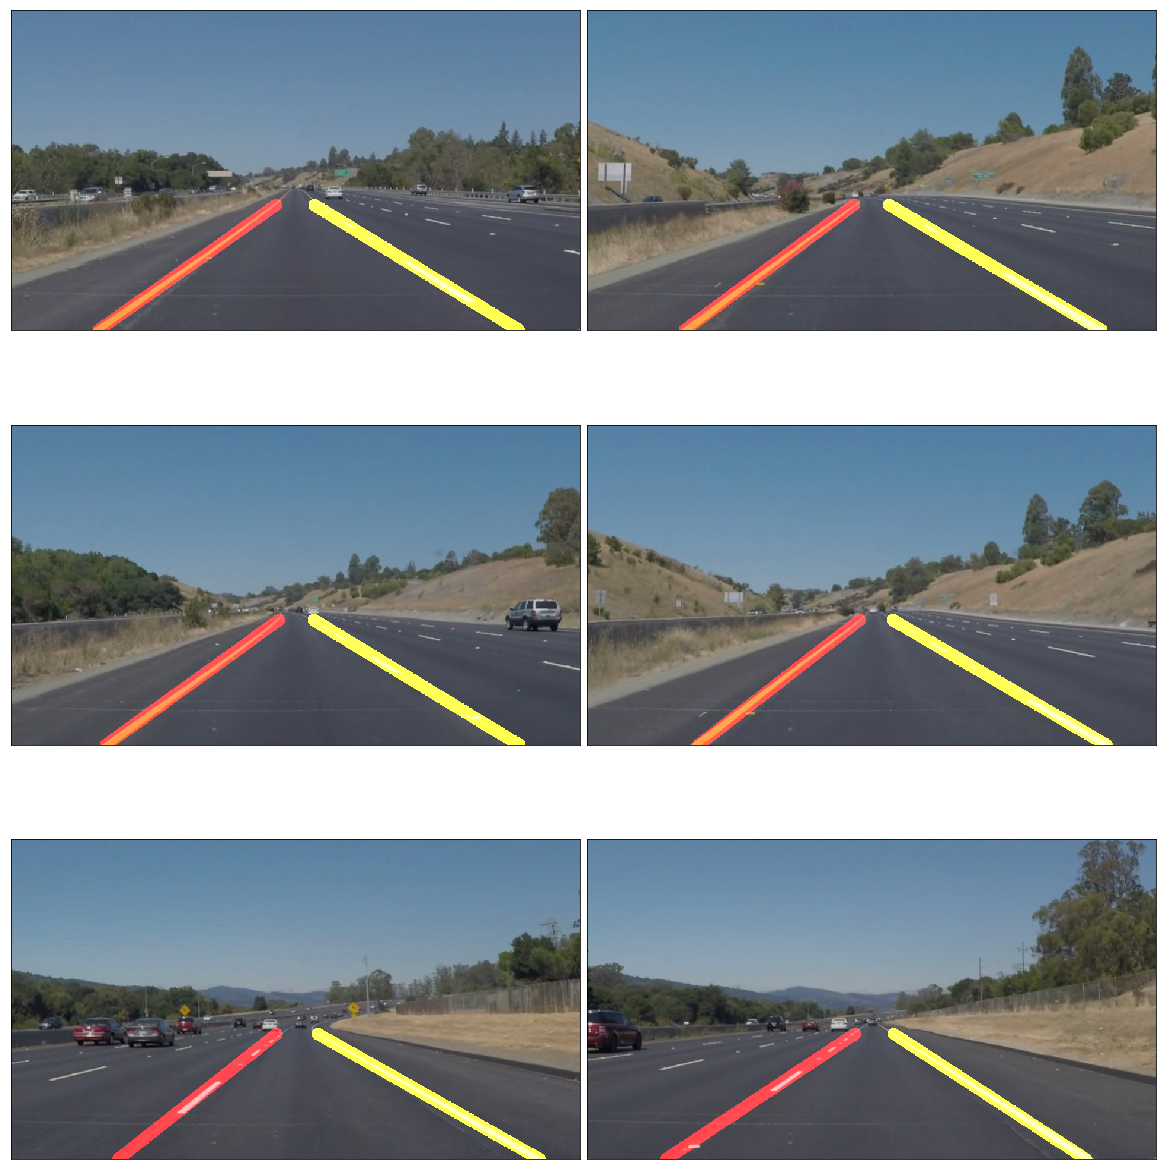

In [15]:
def draw_lane_lines(image, lines):
    # Create a "color" binary image to combine with line image
    #color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, lines, 1, 0)
    return lines_edges
lane_images = [draw_lane_lines(image, lines) for (image, lines) in zip(test_images, color_edges)]
#for image, lines in zip(test_images, color_edges):
#    line_edges = draw_lane_lines(image, lines)
#    lane_images.append(line_edges)
                       
show_images(lane_images)

In [16]:
global left_aveg
global right_aveg

left_aveg  = np.array([0,0])
right_aveg = np.array([0,0])
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    global right_aveg
    global left_aveg
    gray = make_them_gray(image)
    blurred = smoothing(gray)
    edges = make_Canny_edges(blurred)
    masked_edges = select_region(edges)
    list_of_lines = hough_lines(masked_edges)
    averages = average_slope(list_of_lines, right_aveg, left_aveg)
    if(len(averages)>2):
        right_aveg = averages[2]
        left_aveg  = averages[3]
    color_edges = create_lines_average(averages, 20, image)
    lane_images = draw_lane_lines(image, color_edges)
    return lane_images

#process_image(test_images[0])

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:21<00:00, 11.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 23.7 s, sys: 2.25 s, total: 26 s
Wall time: 24.7 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.2 s, sys: 2.79 s, total: 16 s
Wall time: 25.6 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.3 s, sys: 911 ms, total: 5.21 s
Wall time: 8.42 s


In [23]:



HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))